# Proyecto Final: Identificación de Operadores Ineficaces en CallMeMaybe

## Introducción

CallMeMaybe es un servicio de telefonía virtual utilizado por organizaciones para gestionar grandes volúmenes de llamadas entrantes y salientes, así como comunicaciones internas entre operadores. La empresa busca optimizar la eficiencia de su equipo de operadores mediante la detección de aquellos que presenten bajo rendimiento.

En este proyecto, realizaremos un análisis exhaustivo de los datos proporcionados por CallMeMaybe con el objetivo de identificar operadores ineficaces. Consideraremos como ineficaz a un operador si:

- Tiene una gran cantidad de llamadas entrantes perdidas (internas y/o externas).
- Presenta tiempos de espera prolongados en llamadas entrantes.
- Realiza pocas llamadas salientes cuando su rol lo requiere.

### Objetivos del proyecto:

1. Realizar un análisis exploratorio de datos (EDA) para conocer el comportamiento general del sistema de llamadas.
2. Identificar a los operadores con bajo rendimiento utilizando métricas clave.
3. Realizar pruebas estadísticas para confirmar nuestras hipótesis.
4. Crear visualizaciones que respalden los hallazgos y faciliten su interpretación.
5. Documentar las fuentes utilizadas y entregar una presentación final en formato PDF.

Este análisis será clave para que CallMeMaybe implemente herramientas de monitoreo y mejora continua en sus operaciones.


In [1]:
# Librerías para análisis de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para pruebas estadísticas
from scipy import stats

# Configuraciones de visualización
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-poster')
# Para mostrar mejor en Jupyter Notebook
from IPython.display import display

In [2]:
# Cargar el dataset de clientes
clients_df = pd.read_csv(
    r'C:\Users\starc\anaconda_projects\work_dir\Proyectos\ProyectoFinalSprint14\Telecomunicaciones\telecom_clients_us.csv'
)

# Cargar el dataset principal de llamadas
data_df = pd.read_csv(
    r'C:\Users\starc\anaconda_projects\work_dir\Proyectos\ProyectoFinalSprint14\Telecomunicaciones\telecom_dataset_us.csv'
)


## Análisis exploratorio de datos (EDA)

In [3]:
# Revisar clientes
print("=== DataFrame: clients_df ===")
clients_df.info()
display(clients_df.head())

# Revisar data
print("\n=== DataFrame: data_df ===")
data_df.info()
display(data_df.head())


=== DataFrame: clients_df ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16



=== DataFrame: data_df ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


**De inicio, en clients_df debemos tratar con el tipo de datos para poder trabajar de forma adecuada, convirtiendo user_id a object y date_start a datetime, con info() hemos confirmado que no hay valores nulos pero debemos checar los duplicados y ahondaremos en los valores de tariff_plan y date_start, obteniendo los valores unicos y el rango de fechas respectivamente**

In [4]:
# 1. Convertir tipos
clients_df['user_id'] = clients_df['user_id'].astype(str)
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'], format='%Y-%m-%d')

# 2. Verificar duplicados exactos
print('Duplicados exactos:', clients_df.duplicated().sum())

# 2b. Verificar IDs duplicados
print('IDs duplicados:', clients_df['user_id'].duplicated().sum())

# 4. Valores únicos en tarifa
print('Planes disponibles:', clients_df['tariff_plan'].unique())

# 5. Rango de fechas
print('Rango de fechas:', clients_df['date_start'].min(), 'a', clients_df['date_start'].max())


Duplicados exactos: 0
IDs duplicados: 0
Planes disponibles: ['A' 'C' 'B']
Rango de fechas: 2019-08-01 00:00:00 a 2019-10-31 00:00:00


Hemos confirmado que no hay duplicados exactos y tampoco de user_id, tampoco hay valores extraños en los planes de tarifa, y ahora conocemos que la data que tenemos es de un periodo de 3 meses

**Para data_df hay algunas correcciones necesarias, principalmente conversion de tipos en las columnas y tratar con valores nulos**

In [5]:
# Convertir tipos
data_df['user_id'] = data_df['user_id'].astype(str)
data_df['date'] = pd.to_datetime(data_df['date'], utc=True)  # Convierte con zona horaria a UTC
data_df['operator_id'] = data_df['operator_id'].astype('object')

# Convertir directamente a tipo booleano con soporte para nulos
data_df['internal'] = data_df['internal'].astype('boolean')
data_df['is_missed_call'] = data_df['is_missed_call'].astype('boolean')


In [6]:
# Verificar porcentaje de nulos en internal
pct_nulos = data_df['internal'].isna().mean() * 100
print(f"Porcentaje de nulos en 'internal': {pct_nulos:.2f}%")

# Si es bajo, eliminar filas con nulos en internal
if pct_nulos < 5:
    data_df = data_df.dropna(subset=['internal'])
    print(f"Filas con nulos en 'internal' eliminadas, nuevo tamaño: {data_df.shape[0]}")
else:
    print("Hay muchos nulos en 'internal', considerar otro tratamiento")
    

Porcentaje de nulos en 'internal': 0.22%
Filas con nulos en 'internal' eliminadas, nuevo tamaño: 53785


Hemos convertido user_id a object, date a fecha, operator_id a object y estandarizado los booleanos

En internal hemos eliminado los valores nulos al representar menos del 1% de nuestra data, así mantenemos una mayor calidad en nuestros datos sin representar una pérdida relevante de información.

**Ahora, para los valores nulos en operator_id**

Estado actual:
operator_id: 45670 non-null de 53785 → ~15% nulos

¿Qué representa operator_id?
Por lo general, en datasets de telecomunicaciones como este, operator_id representa al operador externo (otro proveedor de red) al que se dirigió la llamada (por ejemplo, Telcel, AT&T, etc.). 
Solo aplica en llamadas salientes externas.
Por tanto, es normal que esté vacío en llamadas entrantes o internas.

**Diagnóstico: ¿cuándo falta operator_id?**


In [7]:
data_df[data_df['operator_id'].isna()]['direction'].value_counts()


direction
in     7917
out     198
Name: count, dtype: int64

In [8]:
pd.crosstab(data_df['operator_id'].isna(), [data_df['direction'], data_df['internal']])


direction       in          out      
internal     False True   False True 
operator_id                          
False        13535   418  26326  5391
True          7603   314    157    41

¿Qué observamos?

La mayoría de los valores nulos están en llamadas entrantes externas (direction = in, internal = False):
Esto tiene sentido: no necesitas conocer al operador del que proviene una llamada entrante.
Casi no hay nulos en llamadas salientes externas (out y internal = False):
Eso también es bueno: ahí sí debería haber operador y los datos lo cumplen casi perfectamente.

**Crearemos valores nuevos para los valores nulos en operator_id que representará la informacion que ahora conocemos**

In [9]:
data_df.loc[(data_df['operator_id'].isna()) & (data_df['direction'] == 'in'), 'operator_id'] = 'incoming'
data_df.loc[(data_df['operator_id'].isna()) & (data_df['internal'] == True), 'operator_id'] = 'internal'
data_df['operator_id'] = data_df['operator_id'].fillna('other')


In [10]:
# verificar de nuevo los datos con los cambios realizados

display(clients_df.head())
clients_df.info()

display(data_df.head())
data_df.info()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    object        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.3+ KB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-03 21:00:00+00:00,in,False,incoming,True,2,0,4
1,166377,2019-08-04 21:00:00+00:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-04 21:00:00+00:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   user_id              53785 non-null  object             
 1   date                 53785 non-null  datetime64[ns, UTC]
 2   direction            53785 non-null  object             
 3   internal             53785 non-null  boolean            
 4   operator_id          53785 non-null  object             
 5   is_missed_call       53785 non-null  boolean            
 6   calls_count          53785 non-null  int64              
 7   call_duration        53785 non-null  int64              
 8   total_call_duration  53785 non-null  int64              
dtypes: boolean(2), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 3.5+ MB


Crearemos la métrica clave 'waiting_duration' para realizar las comparaciones con respecto a los tiempos de espera exclusivamente de llamadas entrantes, punto importante a considerar al clasificar un operador ineficaz

In [11]:
data_df['waiting_duration'] = data_df['total_call_duration'] - data_df['call_duration']


display(data_df[['total_call_duration', 'call_duration', 'waiting_duration', 'is_missed_call']].head())
display(data_df[['total_call_duration', 'call_duration', 'waiting_duration']].describe())


,total_call_duration,call_duration,waiting_duration,is_missed_call
0,4,0,4,True
1,5,0,5,True
2,1,0,1,True
3,18,10,8,False
4,25,0,25,True


,total_call_duration,call_duration,waiting_duration
count,53785.000000,53785.000000,53785.000000
mean,1159.476174,868.436162,291.040011
std,4407.963966,3735.653323,1129.059868
min,0.000000,0.000000,0.000000
25%,47.000000,0.000000,17.000000
50%,211.000000,38.000000,55.000000
75%,905.000000,574.000000,202.000000
max,166155.000000,144395.000000,46474.000000


Podemos observar claramente que tenemos valores que alteran nuestras métricas en describe() y las vuelven algo con poco sentido, verificaremos la distribución de nuestra data de acuerdo a los percentiles y haremos un filtro adecuado

In [12]:
# Obesrvar la distribucion de los datos
display(data_df[['total_call_duration', 'call_duration', 'waiting_duration']].quantile([0.90, 0.95, 0.99, 0.999]))

# Obtener umbrales de percentil 0.99
quantiles = data_df[['total_call_duration', 'call_duration', 'waiting_duration']].quantile(0.99)

# Aplicar filtro conjunto
data_df = data_df[
    (data_df['total_call_duration'] <= quantiles['total_call_duration']) &
    (data_df['call_duration'] <= quantiles['call_duration']) &
    (data_df['waiting_duration'] <= quantiles['waiting_duration'])
]

display(data_df[['total_call_duration', 'call_duration', 'waiting_duration']].quantile([0.90, 0.95, 0.99, 0.999]))


,total_call_duration,call_duration,waiting_duration
0.900,2630.600,2112.600,615.000
0.950,4550.800,3749.000,1167.000
0.990,12958.080,10346.320,3160.560
0.999,69383.648,58511.896,15978.912


,total_call_duration,call_duration,waiting_duration
0.900,2325.0,1935.0,543.0
0.950,3748.0,3248.0,947.0
0.990,7966.0,6961.0,1963.0
0.999,11329.3,9860.5,2947.0


In [13]:
# Crearemos un df para observar el desempeño de los operadores

operator_stats = data_df.groupby('operator_id').agg({
    'waiting_duration': 'mean',
    'is_missed_call': 'mean',
    'user_id': 'count'
}).rename(columns={
    'waiting_duration': 'avg_waiting_duration',
    'is_missed_call': 'missed_call_rate',
    'user_id': 'num_calls'
}).sort_values(by='avg_waiting_duration', ascending=False)

display(operator_stats.head(10))
display(operator_stats.describe())

,avg_waiting_duration,missed_call_rate,num_calls
operator_id,,,
919364.0,2136.461538,0.230769,26
919362.0,1954.555556,0.592593,27
919302.0,1953.523810,0.904762,21
919162.0,1921.218750,0.5625,32
945286.0,1908.016949,0.542373,59
919504.0,1882.888889,0.518519,27
945904.0,1833.593750,0.53125,32
945900.0,1777.693878,0.489796,49
919314.0,1737.833333,0.5,30


,avg_waiting_duration,missed_call_rate,num_calls
count,1095.000000,1095.0,1095.000000
mean,183.360774,0.319364,48.311416
std,337.711557,0.237616,242.516365
min,0.000000,0.0,1.000000
25%,23.000000,0.128906,6.000000
50%,46.234043,0.333333,21.000000
75%,154.000000,0.460769,54.000000
max,2136.461538,1.0,7872.000000


Haremos una nueva columna que identificará a los operadores como ineficientes, según el criterio de los percentiles 75% para los tiempos de espera y la tasa de llamadas perdidas, para que el análisis tenga cierto sentido estadístico tomaremos a los operadores que tienen una cantidad minima de 10 observaciones para el filtro

In [14]:
# Crearemos la nueva columna

operator_stats['is_inefficient'] = (
    (operator_stats['avg_waiting_duration'] > 154) & # Tomando en cuenta el valor del 75%
    (operator_stats['missed_call_rate'] > 0.46) & # Tomando en cuenta el valor del 75%
    (operator_stats['num_calls'] >= 10) # Filtrar operadores con suficientes llamadas para que la muestra tenga peso estadístico.
)

display(operator_stats['is_inefficient'].value_counts())
display(operator_stats[operator_stats['is_inefficient']].sort_values(by='avg_waiting_duration', ascending=False).head(10))


is_inefficient
False    979
True     116
Name: count, dtype: Int64

,avg_waiting_duration,missed_call_rate,num_calls,is_inefficient
operator_id,,,,
919362.0,1954.555556,0.592593,27,True
919302.0,1953.523810,0.904762,21,True
919162.0,1921.218750,0.5625,32,True
945286.0,1908.016949,0.542373,59,True
919504.0,1882.888889,0.518519,27,True
945904.0,1833.593750,0.53125,32,True
945900.0,1777.693878,0.489796,49,True
919314.0,1737.833333,0.5,30,True
945278.0,1683.363636,0.727273,33,True


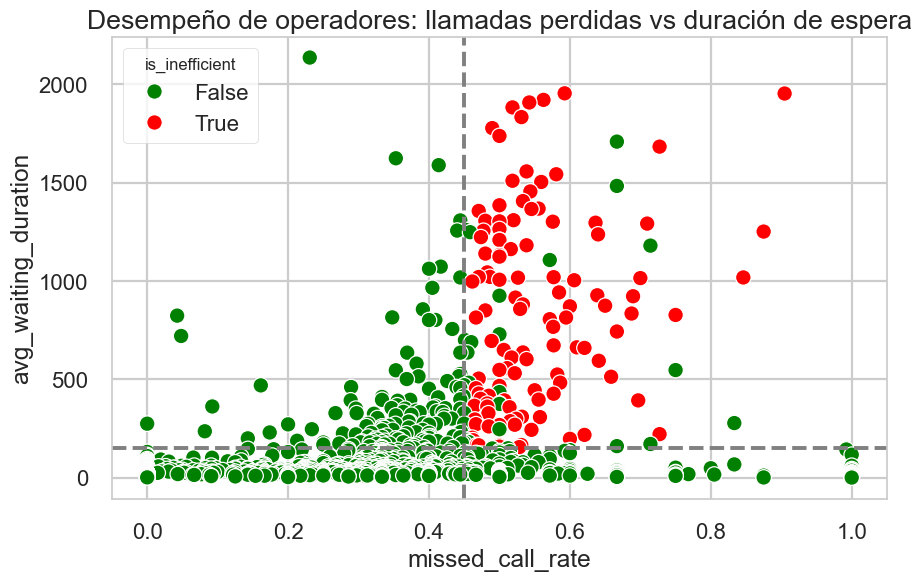

In [15]:
# Visualizar por tasa de llamadas perdidas vs tiempo de espera promedio teniendo a los inecicientes en rojo

plt.figure(figsize=(10, 6))
sns.scatterplot(data=operator_stats, x='missed_call_rate', y='avg_waiting_duration', hue='is_inefficient', palette={True: 'red', False: 'green'})
plt.axhline(150, linestyle='--', color='gray')
plt.axvline(0.45, linestyle='--', color='gray')
plt.title('Desempeño de operadores: llamadas perdidas vs duración de espera')
plt.show()


In [16]:
# Calcular el percentil 25 de num_calls
q1_calls = operator_stats['num_calls'].quantile(0.25)

# Crear columna para identificar operadores con pocas llamadas
operator_stats['is_low_activity'] = operator_stats['num_calls'] < q1_calls

# Mostrar conteo de operadores con baja actividad
display(operator_stats['is_low_activity'].value_counts())

# Mostrar ejemplos
display(operator_stats[operator_stats['is_low_activity']].sort_values(by='missed_call_rate', ascending = False).head(10))


is_low_activity
False    824
True     271
Name: count, dtype: int64

,avg_waiting_duration,missed_call_rate,num_calls,is_inefficient,is_low_activity
operator_id,,,,,
958458.0,0.0,1.0,1,False,True
883018.0,15.0,1.0,1,False,True
969284.0,4.0,1.0,1,False,True
937772.0,18.0,1.0,1,False,True
905480.0,5.0,1.0,1,False,True
885682.0,17.0,1.0,3,False,True
969262.0,17.0,1.0,1,False,True
928282.0,8.0,1.0,2,False,True
970250.0,8.0,1.0,1,False,True


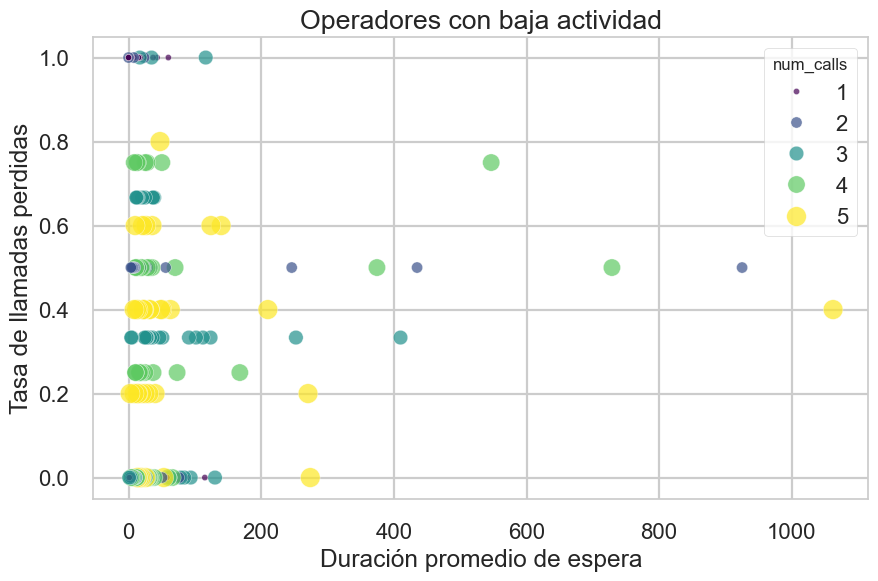

In [17]:
# Solo los de baja actividad
low_activity = operator_stats[operator_stats['is_low_activity']]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=low_activity,
    x='avg_waiting_duration',
    y='missed_call_rate',
    size='num_calls',
    hue='num_calls',
    palette='viridis',
    sizes=(20, 200),
    alpha=0.7
)
plt.title('Operadores con baja actividad')
plt.xlabel('Duración promedio de espera')
plt.ylabel('Tasa de llamadas perdidas')
plt.grid(True)
plt.show()


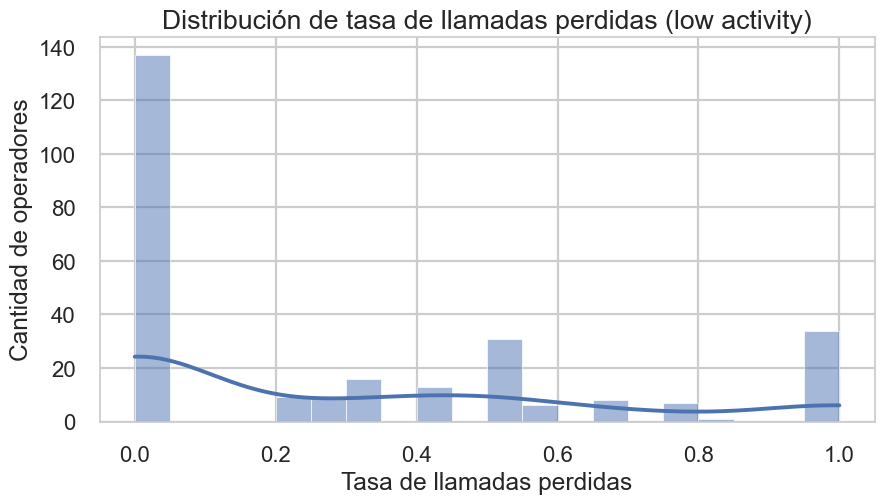

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(low_activity['missed_call_rate'], bins=20, kde=True)
plt.title('Distribución de tasa de llamadas perdidas (low activity)')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Cantidad de operadores')
plt.grid(True)
plt.show()


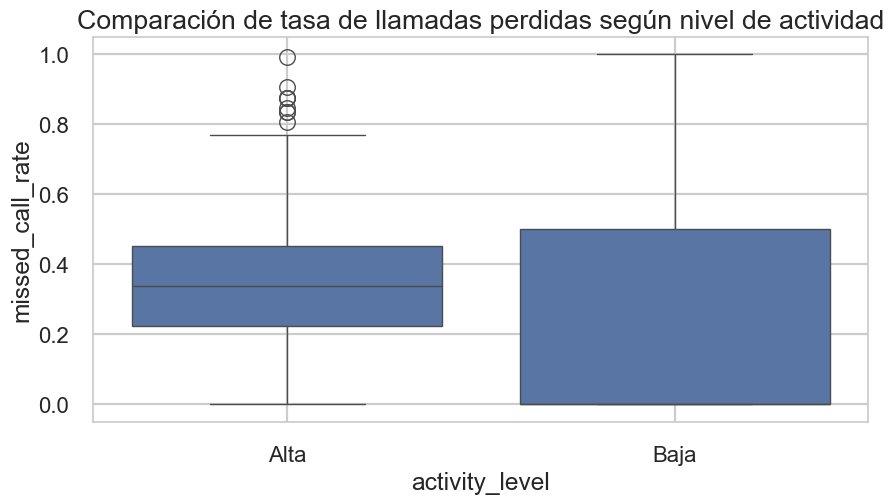

In [19]:
# Comparación entre baja y alta actividad
operator_stats['activity_level'] = operator_stats['is_low_activity'].map({True: 'Baja', False: 'Alta'})

plt.figure(figsize=(10,5))
sns.boxplot(data=operator_stats, x='activity_level', y='missed_call_rate')
plt.title('Comparación de tasa de llamadas perdidas según nivel de actividad')
plt.grid(True)
plt.show()


In [20]:
# Filtrar sólo los operadores de baja actividad
low_activity_ids = operator_stats[operator_stats['is_low_activity']].index

# Filtrar el dataframe original
low_activity_df = data_df[data_df['operator_id'].isin(low_activity_ids)]

# Ver algunos registros ordenados por operador y fecha
display(low_activity_df.sort_values(by=['operator_id', 'date']).head(10))


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_duration
571,166391,2019-08-05 21:00:00+00:00,in,False,882476.0,False,1,175,186,11
584,166391,2019-09-22 21:00:00+00:00,in,False,882476.0,False,1,4,24,20
590,166391,2019-11-21 21:00:00+00:00,in,False,882476.0,False,1,13,77,64
573,166391,2019-08-06 21:00:00+00:00,in,True,882478.0,False,2,11,74,63
574,166391,2019-08-06 21:00:00+00:00,in,False,882478.0,False,1,57,70,13
575,166391,2019-08-06 21:00:00+00:00,out,True,882478.0,True,1,0,7,7
4350,166507,2019-08-06 21:00:00+00:00,out,False,883018.0,True,2,0,15,15
4352,166507,2019-08-06 21:00:00+00:00,out,False,883898.0,False,1,70,80,10
2804,166481,2019-08-08 21:00:00+00:00,in,False,884294.0,False,1,5,11,6
4025,166503,2019-09-10 21:00:00+00:00,out,True,884402.0,True,1,0,28,28


In [21]:
# Calcular el rango de actividad
low_activity_dates = (
    low_activity_df.groupby('operator_id')['date']
    .agg(['min', 'max', 'count'])
    .rename(columns={'min': 'first_call', 'max': 'last_call', 'count': 'total_calls'})
)

# Agregar columna con el rango de días
low_activity_dates['activity_days'] = (low_activity_dates['last_call'] - low_activity_dates['first_call']).dt.days

# Mostrar los primeros resultados ordenados por mayor rango de días
display(low_activity_dates.sort_values(by='activity_days', ascending=False).head(10))

len(low_activity_dates)
low_activity_dates.describe()


,first_call,last_call,total_calls,activity_days
operator_id,,,,
882476.0,2019-08-05 21:00:00+00:00,2019-11-21 21:00:00+00:00,3,108
914172.0,2019-09-20 21:00:00+00:00,2019-11-17 21:00:00+00:00,4,58
923254.0,2019-09-29 21:00:00+00:00,2019-11-26 21:00:00+00:00,4,58
928092.0,2019-10-03 21:00:00+00:00,2019-11-27 21:00:00+00:00,3,55
899892.0,2019-08-28 21:00:00+00:00,2019-10-20 21:00:00+00:00,3,53
901498.0,2019-09-01 21:00:00+00:00,2019-10-21 21:00:00+00:00,4,50
889638.0,2019-08-15 21:00:00+00:00,2019-10-04 21:00:00+00:00,3,50
888520.0,2019-08-24 21:00:00+00:00,2019-10-13 21:00:00+00:00,5,50
930510.0,2019-10-08 21:00:00+00:00,2019-11-26 21:00:00+00:00,4,49


,total_calls,activity_days
count,271.000000,271.000000
mean,2.638376,7.959410
std,1.404439,14.292261
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,1.000000
75%,4.000000,9.000000
max,5.000000,108.000000


Hemos descubierto que tenemos operadores con menos de 6 llamadas en un periodo prolongado (1 mes) relativamente a nuestra prueba de 3 meses, marcaremos como ineficientes a estos operadores también

In [22]:
# Condición: poca actividad + periodo amplio
low_but_old = (
    (operator_stats['is_low_activity']) &
    (low_activity_dates['activity_days'] > 30)
)

# Actualizamos los operadores marcándolos como ineficientes también
operator_stats.loc[low_but_old, 'is_inefficient'] = True


In [23]:
# Cuántos nuevos fueron marcados como ineficientes
print("Nuevos ineficientes por baja actividad prolongada:", low_but_old.sum())

# Conteo final
display(operator_stats['is_inefficient'].value_counts())


Nuevos ineficientes por baja actividad prolongada: 21


is_inefficient
False    958
True     137
Name: count, dtype: Int64

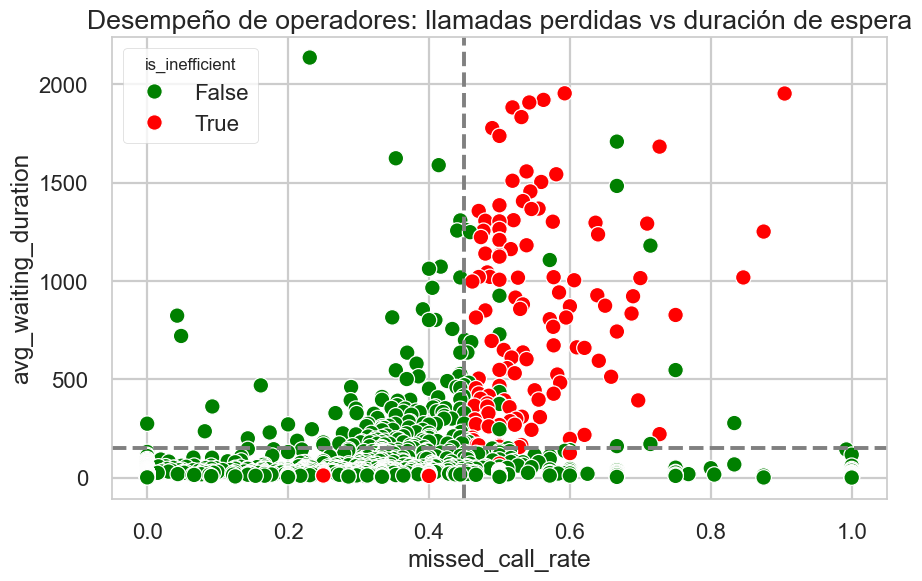

In [24]:
# Visualizar por tasa de llamadas perdidas vs tiempo de espera promedio teniendo a los inecicientes en rojo

plt.figure(figsize=(10, 6))
sns.scatterplot(data=operator_stats, x='missed_call_rate', y='avg_waiting_duration', hue='is_inefficient', palette={True: 'red', False: 'green'})
plt.axhline(150, linestyle='--', color='gray')
plt.axvline(0.45, linestyle='--', color='gray')
plt.title('Desempeño de operadores: llamadas perdidas vs duración de espera')
plt.show()

## Conclusión del Análisis de Eficiencia de Operadores

A lo largo del análisis, se identificaron operadores ineficientes a partir de dos enfoques complementarios:

1. **Desempeño deficiente con volumen significativo**  
   Se clasificaron como ineficientes aquellos operadores que presentaron:
   - Un tiempo promedio de espera por encima del percentil 75 (más de 154 segundos).
   - Una tasa de llamadas perdidas también superior al percentil 75 (más de 46%).
   - Al menos 10 llamadas, para asegurar relevancia estadística.

2. **Baja actividad prolongada**  
   Se identificaron operadores con menos de 6 llamadas totales y más de 30 días entre su primera y última actividad. Aunque su volumen es bajo, su permanencia en el sistema sin mejora justifica una revisión.

### Resultados clave:
- Total de operadores analizados: **1095**
- Operadores identificados como ineficientes: **137**
  - Por desempeño deficiente: **116**
  - Por baja actividad prolongada: **21**

### Recomendaciones:
- **Revisión individual** de los operadores ineficientes para determinar causas específicas (capacitación, rotación, saturación, etc.).
- **Monitoreo continuo** de los operadores de baja actividad para evitar que permanezcan sin uso productivo durante periodos prolongados.
- **Ajustes operativos** o de políticas internas basados en estos hallazgos.

Este enfoque mixto permite no solo detectar problemas actuales de desempeño, sino también anticipar posibles ineficiencias estructurales dentro del equipo operativo.


In [25]:
# Creamos un df para crear el dashboard en Tableau

# Hacemos merge para combinar los detalles de cada llamada con la info del operador
merged_df = data_df.merge(
    operator_stats[['is_inefficient', 'is_low_activity']], 
    how='left', 
    left_on='operator_id', 
    right_index=True
)

# Verificar que todo esté en orden
display(merged_df.head(10))

# Crear archivo csv para utilizar Tableau
merged_df.to_csv("merged_calls_data.csv", index=False)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_duration,is_inefficient,is_low_activity
0,166377,2019-08-03 21:00:00+00:00,in,False,incoming,True,2,0,4,4,False,False
1,166377,2019-08-04 21:00:00+00:00,out,True,880022.0,True,3,0,5,5,False,False
2,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,True,1,0,1,1,False,False
3,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,False,1,10,18,8,False,False
4,166377,2019-08-04 21:00:00+00:00,out,False,880022.0,True,3,0,25,25,False,False
5,166377,2019-08-04 21:00:00+00:00,out,False,880020.0,False,2,3,29,26,False,False
6,166377,2019-08-04 21:00:00+00:00,out,False,880020.0,True,8,0,50,50,False,False
7,166377,2019-08-04 21:00:00+00:00,in,False,incoming,True,6,0,35,35,False,False
8,166377,2019-08-04 21:00:00+00:00,out,False,880020.0,True,8,0,50,50,False,False
9,166377,2019-08-05 21:00:00+00:00,in,False,incoming,True,4,0,62,62,False,False
